
# Bayesian Linear Regression in PyMC
This notebook accompanies lecture slides on prior specification in Bayesian linear regression.

It demonstrates four prior families in PyMC:
- **Improper priors** (flat on $\beta$, Jeffreys on $\sigma$)
- **Gaussian priors**
  - Zellner's **g-prior** (multivariate)
  - **Independent Gaussian** (ridge-style)
- **Bayesian LASSO** (Laplace prior; optional hierarchical shrinkage)
- **Spike-and-Slab** (discrete inclusion indicators)

> **Tip:** For reproducibility in Colab, run the cells from top to bottom.


In [ ]:
# Install required packages in Colab
!pip -q install pymc arviz pytensor --upgrade


## Imports and helpers

In [ ]:

from __future__ import annotations
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import warnings

warnings.filterwarnings("ignore")

def standardize(X: np.ndarray, y: np.ndarray):
    """Center and scale columns of X and y to mean 0, variance 1.
    Returns standardized (Xz, yz), plus the shifts/scales for back-transforms.
    """
    X_mean = X.mean(axis=0)
    X_std = X.std(axis=0, ddof=0)
    X_std[X_std == 0] = 1.0
    Xz = (X - X_mean) / X_std

    y_mean = y.mean()
    y_std = y.std(ddof=0)
    if y_std == 0:
        y_std = 1.0
    yz = (y - y_mean) / y_std
    return Xz, yz, (X_mean, X_std, y_mean, y_std)

def toy_data(n: int = 200, p: int = 20, seed: int = 123):
    """Simulate standardized toy data with sparse true betas for classroom demos."""
    rng = np.random.default_rng(seed)
    X = rng.normal(size=(n, p))
    beta_true = np.zeros(p)
    beta_true[:4] = [1.5, -1.0, 0.75, 0.5]
    beta0_true = 0.0
    eps = rng.normal(scale=1.0, size=n)
    y = beta0_true + X @ beta_true + eps
    Xz, yz, scales = standardize(X, y)
    return Xz, yz, beta_true, beta0_true, scales

# Data (replace with your own X, y if desired)
X, y, beta_true, beta0_true, _scales = toy_data(n=500, p=100, seed=2025)
n, p = X.shape
XtX = X.T @ X
XtX_inv = np.linalg.pinv(XtX)
print(f"Data shape: X={X.shape}, y={y.shape}")


Data shape: X=(500, 100), y=(500,)



## 1) Improper priors
Flat prior on $\beta$ (`pm.Flat`) and Jeffreys prior on $\sigma$ (`pm.HalfFlat`).


In [ ]:

def fit_improper(X, y, draws=1000, tune=1000, chains=4, seed=42):
    n, p = X.shape
    with pm.Model() as m:
        beta0 = pm.Flat("beta0")
        beta  = pm.Flat("beta", shape=p)
        sigma = pm.HalfFlat("sigma")  # Jeffreys prior for Normal likelihood

        mu = beta0 + pm.math.dot(X, beta)
        pm.Normal("y", mu=mu, sigma=sigma, observed=y)

        idata = pm.sample(draws=draws, tune=tune, chains=chains, random_seed=seed, target_accept=0.9)
        ppc = pm.sample_posterior_predictive(idata, random_seed=seed)
        idata.extend(ppc)
    return m, idata

m_flat, id_flat = fit_improper(X, y, draws=800, tune=800, chains=2)
az.summary(id_flat, var_names=["beta0","beta","sigma"]).round(3)


Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-0.000,0.022,-0.041,0.043,0.0,0.001,3397.0,1040.0,1.0
beta[0],0.645,0.024,0.602,0.692,0.0,0.001,2590.0,1155.0,1.0
beta[1],-0.443,0.024,-0.486,-0.397,0.0,0.000,2864.0,1475.0,1.0
beta[2],0.349,0.021,0.311,0.390,0.0,0.000,2153.0,1245.0,1.0
beta[3],0.238,0.023,0.196,0.278,0.0,0.001,2627.0,1318.0,1.0
...,...,...,...,...,...,...,...,...,...
beta[96],-0.006,0.025,-0.059,0.035,0.0,0.001,2716.0,1087.0,1.0
beta[97],-0.006,0.024,-0.051,0.037,0.0,0.001,3383.0,1309.0,1.0
beta[98],0.016,0.024,-0.027,0.063,0.0,0.001,2773.0,1274.0,1.0
beta[99],-0.008,0.023,-0.053,0.033,0.0,0.001,3156.0,1355.0,1.0



## 2a) Gaussian prior — Zellner's g-prior
$\beta\mid\sigma^2 \sim \mathcal{N}\left(0, \frac{\sigma^2}{g}(X^\top X)^{-1}\right)$. Common default: `g = n`.


In [ ]:

def fit_gprior(X, y, g=None, draws=1000, tune=1000, chains=4, seed=43):
    n, p = X.shape
    XtX_inv = np.linalg.pinv(X.T @ X)
    if g is None:
        g = float(n)
    with pm.Model() as m:
        beta0 = pm.Flat("beta0")
        sigma = pm.HalfFlat("sigma")
        cov_beta = (sigma**2 / g) * XtX_inv
        beta = pm.MvNormal("beta", mu=pt.zeros(p), cov=cov_beta)

        mu = beta0 + pm.math.dot(X, beta)
        pm.Normal("y", mu=mu, sigma=sigma, observed=y)

        idata = pm.sample(draws=draws, tune=tune, chains=chains, random_seed=seed, target_accept=0.9)
        ppc = pm.sample_posterior_predictive(idata, random_seed=seed)
        idata.extend(ppc)
    return m, idata

m_g, id_g = fit_gprior(X, y, g=n, draws=800, tune=800, chains=2)
az.summary(id_g, var_names=["beta0","beta","sigma"]).round(3)


Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-0.001,0.045,-0.084,0.083,0.001,0.001,4663.0,1023.0,1.0
beta[0],0.001,0.002,-0.003,0.006,0.000,0.000,2862.0,1221.0,1.0
beta[1],-0.001,0.002,-0.005,0.004,0.000,0.000,2804.0,1301.0,1.0
beta[2],0.001,0.002,-0.003,0.005,0.000,0.000,2910.0,1663.0,1.0
beta[3],0.000,0.002,-0.004,0.005,0.000,0.000,3122.0,1282.0,1.0
...,...,...,...,...,...,...,...,...,...
beta[96],0.000,0.002,-0.004,0.004,0.000,0.000,2803.0,1239.0,1.0
beta[97],-0.000,0.002,-0.004,0.004,0.000,0.000,2404.0,1483.0,1.0
beta[98],-0.000,0.002,-0.004,0.004,0.000,0.000,2676.0,1110.0,1.0
beta[99],0.000,0.002,-0.004,0.004,0.000,0.000,2996.0,1220.0,1.0



## 2b) Gaussian priors — Independent Normal (ridge-style)
$\beta_j \sim \mathcal{N}(0, \sigma^2/g)$. Posterior mode coincides with ridge regression.


In [ ]:

def fit_independent_normal(X, y, g=10.0, draws=1000, tune=1000, chains=4, seed=44):
    n, p = X.shape
    with pm.Model() as m:
        beta0 = pm.Flat("beta0")
        sigma = pm.HalfFlat("sigma")
        sd_beta = sigma / np.sqrt(g)
        beta = pm.Normal("beta", mu=0.0, sigma=sd_beta, shape=p)

        mu = beta0 + pm.math.dot(X, beta)
        pm.Normal("y", mu=mu, sigma=sigma, observed=y)

        idata = pm.sample(draws=draws, tune=tune, chains=chains, random_seed=seed, target_accept=0.9)
        ppc = pm.sample_posterior_predictive(idata, random_seed=seed)
        idata.extend(ppc)
    return m, idata

m_ridge, id_ridge = fit_independent_normal(X, y, g=10.0, draws=800, tune=800, chains=2)
az.summary(id_ridge, var_names=["beta0","beta","sigma"]).round(3)


Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-0.000,0.018,-0.036,0.033,0.0,0.000,4028.0,1247.0,1.00
beta[0],0.630,0.023,0.588,0.671,0.0,0.001,2364.0,1396.0,1.00
beta[1],-0.429,0.022,-0.468,-0.384,0.0,0.001,3459.0,1320.0,1.00
beta[2],0.339,0.021,0.299,0.377,0.0,0.000,2974.0,1401.0,1.00
beta[3],0.232,0.021,0.190,0.270,0.0,0.001,2650.0,1366.0,1.00
...,...,...,...,...,...,...,...,...,...
beta[96],-0.008,0.021,-0.046,0.031,0.0,0.001,2430.0,1126.0,1.00
beta[97],-0.003,0.022,-0.042,0.040,0.0,0.000,2679.0,1494.0,1.00
beta[98],0.015,0.022,-0.024,0.055,0.0,0.001,2803.0,1111.0,1.00
beta[99],-0.008,0.021,-0.045,0.031,0.0,0.001,2754.0,1233.0,1.01



## 3) Bayesian LASSO (Laplace prior)
Laplace density: $p(\beta_j) = \frac{1}{2b}\exp(-|\beta_j|/b)$ with $b=1/\lambda$. A hierarchical version infers $\lambda$.


In [ ]:

def fit_blasso(X, y, lam=None, hierarchical=True, draws=1200, tune=1200, chains=2, seed=45):
    n, p = X.shape
    with pm.Model() as m:
        beta0 = pm.Flat("beta0")
        sigma = pm.HalfFlat("sigma")

        if hierarchical:
            lam_param = pm.Exponential("lambda", 1.0)
            b = pm.Deterministic("b", 1.0 / lam_param)
        else:
            if lam is None:
                lam = 1.0
            b = pm.Deterministic("b", 1.0 / lam)

        beta = pm.Laplace("beta", mu=0.0, b=b, shape=p)

        mu = beta0 + pm.math.dot(X, beta)
        pm.Normal("y", mu=mu, sigma=sigma, observed=y)

        idata = pm.sample(draws=draws, tune=tune, chains=chains, random_seed=seed, target_accept=0.95)
        ppc = pm.sample_posterior_predictive(idata, random_seed=seed)
        idata.extend(ppc)
    return m, idata

m_blasso, id_blasso = fit_blasso(X, y, hierarchical=True)
az.summary(id_blasso, var_names=["beta0","beta","sigma","lambda","b"]).round(3)


Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,0.000,0.020,-0.036,0.039,0.000,0.000,3306.0,1909.0,1.0
beta[0],0.636,0.022,0.597,0.678,0.000,0.000,2369.0,1837.0,1.0
beta[1],-0.428,0.022,-0.469,-0.387,0.000,0.000,2496.0,1421.0,1.0
beta[2],0.336,0.022,0.292,0.376,0.000,0.000,2729.0,1750.0,1.0
beta[3],0.227,0.021,0.187,0.267,0.000,0.000,3008.0,1664.0,1.0
...,...,...,...,...,...,...,...,...,...
beta[98],0.009,0.018,-0.023,0.044,0.000,0.000,2829.0,1888.0,1.0
beta[99],-0.005,0.018,-0.036,0.030,0.000,0.000,3591.0,1756.0,1.0
sigma,0.452,0.016,0.423,0.482,0.000,0.000,3087.0,1996.0,1.0
lambda,23.397,2.483,18.745,28.033,0.055,0.058,2035.0,1487.0,1.0



## 4) Spike-and-Slab
Binary inclusion indicators with mixed samplers: NUTS (continuous vars) + BinaryMetropolis (indicators).


In [ ]:

def fit_spike_slab(X, y, pi=0.5, c0=0.10, c1=2.50, draws=1500, tune=1500, chains=2, seed=46):
    n, p = X.shape
    with pm.Model() as m:
        beta0 = pm.Flat("beta0")
        sigma = pm.HalfFlat("sigma")
        gamma = pm.Bernoulli("gamma", p=pi, shape=p)
        sd = pm.Deterministic("sd_beta", pt.where(gamma, c1, c0))
        beta = pm.Normal("beta", mu=0.0, sigma=sd, shape=p)

        mu = beta0 + pm.math.dot(X, beta)
        pm.Normal("y", mu=mu, sigma=sigma, observed=y)

        nuts_vars = [beta0, sigma, beta]
        bm_vars = [gamma]
        step = [pm.NUTS(vars=nuts_vars, target_accept=0.95), pm.BinaryMetropolis(vars=bm_vars)]

        idata = pm.sample(draws=draws, tune=tune, chains=chains, step=step, random_seed=seed, cores=None)
        ppc = pm.sample_posterior_predictive(idata, random_seed=seed)
        idata.extend(ppc)

        pip = idata.posterior["gamma"].mean(dim=("chain","draw")).values
        print("Posterior inclusion probabilities (PIP):", np.round(pip, 3))
    return m, idata

m_ss, id_ss = fit_spike_slab(X, y, pi=0.3, c0=0.10, c1=2.5)
az.summary(id_ss, var_names=["beta0","beta","sigma","gamma"]).round(3)


Output()

Output()

Posterior inclusion probabilities (PIP): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,0.000,0.021,-0.039,0.040,0.0,0.0,5500.0,2005.0,1.0
beta[0],0.613,0.023,0.570,0.654,0.0,0.0,3318.0,2472.0,1.0
beta[1],-0.416,0.022,-0.459,-0.376,0.0,0.0,2962.0,2367.0,1.0
beta[2],0.330,0.023,0.287,0.373,0.0,0.0,3015.0,2218.0,1.0
beta[3],0.226,0.023,0.182,0.269,0.0,0.0,4078.0,2144.0,1.0
...,...,...,...,...,...,...,...,...,...
gamma[95],0.000,0.000,0.000,0.000,0.0,NaN,3000.0,3000.0,NaN
gamma[96],0.000,0.000,0.000,0.000,0.0,NaN,3000.0,3000.0,NaN
gamma[97],0.000,0.000,0.000,0.000,0.0,NaN,3000.0,3000.0,NaN
gamma[98],0.000,0.000,0.000,0.000,0.0,NaN,3000.0,3000.0,NaN



## Predictive comparison (optional)
Compute RMSE on posterior predictive means for a quick comparison.


In [ ]:

import numpy as np

def rmse_from_idata(idata, y_obs):
    yrep = idata.posterior_predictive["y"].stack(sample=("chain","draw")).values  # (n, S)
    yrep = yrep.T  # (S, n)
    ypred_mean = yrep.mean(axis=0)
    return float(np.sqrt(np.mean((ypred_mean - y_obs)**2)))

rmse_flat   = rmse_from_idata(id_flat, y)
rmse_g      = rmse_from_idata(id_g, y)
rmse_ridge  = rmse_from_idata(id_ridge, y)
rmse_blasso = rmse_from_idata(id_blasso, y)
rmse_ss     = rmse_from_idata(id_ss, y)

print({
    "improper": rmse_flat,
    "g_prior": rmse_g,
    "indep_normal": rmse_ridge,
    "blasso": rmse_blasso,
    "spike_slab": rmse_ss,
})


{'improper': 0.4127484717227341, 'g_prior': 0.9990143034457959, 'indep_normal': 0.41222679066760937, 'blasso': 0.41617809490710905, 'spike_slab': 0.4147968806020734}



## Quick visuals (optional)
Single-plot diagnostics without specifying styles or colors.


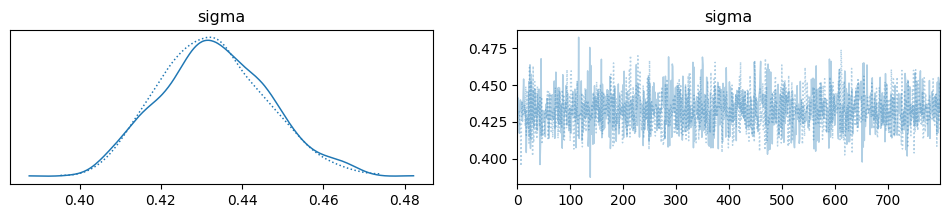

In [ ]:

import matplotlib.pyplot as plt
az.plot_trace(id_ridge, var_names=["sigma"])
plt.show()


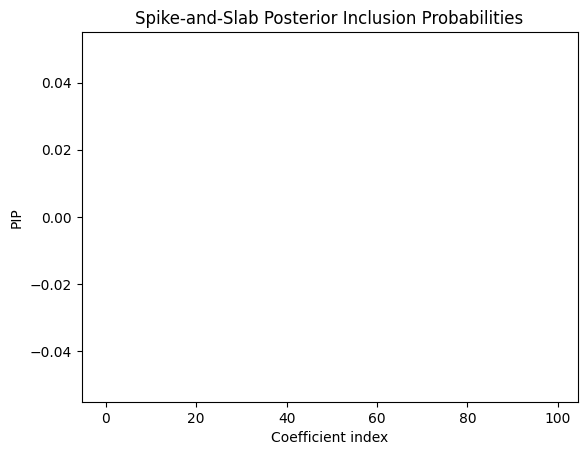

In [ ]:

import matplotlib.pyplot as plt
pip = id_ss.posterior["gamma"].mean(dim=("chain","draw")).values
plt.figure()
plt.bar(range(len(pip)), pip)  # no explicit colors
plt.xlabel("Coefficient index")
plt.ylabel("PIP")
plt.title("Spike-and-Slab Posterior Inclusion Probabilities")
plt.show()
